<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Background" data-toc-modified-id="Data-Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Background</a></span></li><li><span><a href="#Project-Goals" data-toc-modified-id="Project-Goals-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Project Goals</a></span></li><li><span><a href="#General-Data-Cleaning" data-toc-modified-id="General-Data-Cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>General Data Cleaning</a></span></li><li><span><a href="#Borrower-Clustering-Analysis" data-toc-modified-id="Borrower-Clustering-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Borrower Clustering Analysis</a></span><ul class="toc-item"><li><span><a href="#Loan-repayment-ability-x-willingness" data-toc-modified-id="Loan-repayment-ability-x-willingness-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Loan repayment ability x willingness</a></span></li><li><span><a href="#Loan-demand-x-repayment-ability" data-toc-modified-id="Loan-demand-x-repayment-ability-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loan demand x repayment ability</a></span></li><li><span><a href="#Loan-demand-x-repayment-willingness" data-toc-modified-id="Loan-demand-x-repayment-willingness-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Loan demand x repayment willingness</a></span></li></ul></li><li><span><a href="#Loan-Demand-Time-Series-Analysis" data-toc-modified-id="Loan-Demand-Time-Series-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Loan Demand Time Series Analysis</a></span><ul class="toc-item"><li><span><a href="#Check-and-transform-the-data" data-toc-modified-id="Check-and-transform-the-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Check and transform the data</a></span></li><li><span><a href="#ARIMA-model" data-toc-modified-id="ARIMA-model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>ARIMA model</a></span></li></ul></li><li><span><a href="#Loan-Default-Prediction" data-toc-modified-id="Loan-Default-Prediction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Loan Default Prediction</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Prediction-Results" data-toc-modified-id="Prediction-Results-6.2.3"><span class="toc-item-num">6.2.3&nbsp;&nbsp;</span>Prediction Results</a></span></li></ul></li></ul></li></ul></div>

# Loan Data Analysis
Yingcan Carol Wang

## Data Background
For this project, I used a dataset from Lending Club - a US online P2P lending company. Through Lending Club, investors provide funds for borrowers and earn a profit based on the risk they take (depending on the borrowers' credit score). Lending Club makes money by collecting fees from both borrowers and investors. This dataset mostly includes information from the borrower's side, ranging from the year 2007 to 2015.  

## Project Goals
1. Cluster borrowers into different types so as to facilitate targetted marketing and risk management.
<br><br>
2. Forcast and predict overall loan amount to help estimate market demand and run campaigns targeting at borrowers or investors at the right time.
<br><br>
3. Predict bad loan so as to reduce risk for the platform and its investors.


## General Data Cleaning

In [508]:
# Import libraries 
import pandas as pd
import numpy as np
#import tensorflow as tf

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
plt.style.use('fivethirtyeight')

# classifiers and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report 


#statsmodel for time series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
import pmdarima as pm
import arch
from arch import arch_model

# others
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import collections
from collections import Counter
from scipy.stats import boxcox
import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_raw = pd.read_csv('loan.csv', low_memory=False)
df_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_raw.shape

(887379, 74)

The dataset contains 74 columns, but not all of them would be useful for this project. I pick the following features that are most relevant to the three goals of the project:
* loan_amnt
* funded_amnt_inv (the total amount committed by investors for that loan at that point in time)
* term (the number of payments on the loan, either in 36 or 60 months)
* int_rate (interest rate)
* installment
* grade (loan grade based on credit score)
* emp_length (employment time)
* home_ownership
* annual_inc (annual income)
* verification_status (whether income is verified)
* issue_d (the month which the loan was funded)
* loan_status 
* purpose (borrowing purpose)
* addr_state (the US state provided by the borrower as the address)
* dti (debt-income ratio)
* delinq_2yrs (the number of delinquency in the past 2 years)
* inq_last_6mths (the number of inquiries in the past 6 months) 
* total_acc (the total number of current credit lines)
* out_prncp (remaining outstanding principal for total amount funded)
* pub_rec (the number of derogatory public records)
* revol_bal (total credit revolving balance)
* revol_util (the amount of credit the borrower is using relative to all available revolving credit)

In [3]:
df_selected = df_raw[['loan_amnt','funded_amnt_inv','term','int_rate','installment','grade',
                  'emp_length','home_ownership','annual_inc','verification_status','issue_d',
                  'loan_status','purpose',
                  'addr_state','dti','delinq_2yrs','inq_last_6mths',
                  'total_acc',
                  'out_prncp','pub_rec','revol_bal','revol_util']]

In [5]:
# check missing data
df_selected.isnull().sum()

loan_amnt                  0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 4
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
addr_state                 0
dti                        0
delinq_2yrs               29
inq_last_6mths            29
total_acc                 29
out_prncp                  0
pub_rec                   29
revol_bal                  0
revol_util               502
dtype: int64

Since the row number of missing data only takes up ~5% of all rows and there is enough amount of data (887379 rows), deleting them will not affect our statistical power. 

In [4]:
# delete missing data
df_cleaned = df_selected.dropna()
df_cleaned.shape

(842067, 22)

In [7]:
df_cleaned.head(3)

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0.0,1.0,9.0,0.0,0.0,13648.0,83.7
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0.0,5.0,4.0,0.0,0.0,1687.0,9.4
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0.0,2.0,10.0,0.0,0.0,2956.0,98.5


In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842067 entries, 0 to 887378
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            842067 non-null  float64
 1   funded_amnt_inv      842067 non-null  float64
 2   term                 842067 non-null  object 
 3   int_rate             842067 non-null  float64
 4   installment          842067 non-null  float64
 5   grade                842067 non-null  object 
 6   emp_length           842067 non-null  object 
 7   home_ownership       842067 non-null  object 
 8   annual_inc           842067 non-null  float64
 9   verification_status  842067 non-null  object 
 10  issue_d              842067 non-null  object 
 11  loan_status          842067 non-null  object 
 12  purpose              842067 non-null  object 
 13  addr_state           842067 non-null  object 
 14  dti                  842067 non-null  float64
 15  delinq_2yrs      

In [9]:
df_cleaned.describe()

,loan_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util
count,842067.000000,842067.000000,842067.000000,842067.000000,8.420670e+05,842067.000000,842067.000000,842067.000000,842067.000000,842067.000000,842067.000000,8.420670e+05,842067.000000
mean,14915.479321,14860.788718,13.244072,440.779140,7.634501e+04,18.061077,0.317167,0.696321,25.339776,8466.188997,0.189016,1.708633e+04,55.228812
std,8449.246664,8457.198501,4.385640,244.625379,6.563192e+04,8.277712,0.865776,1.000607,11.845235,8554.460606,0.576540,2.261416e+04,23.814760
min,500.000000,0.000000,5.320000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,8325.000000,8150.000000,9.990000,263.930000,4.700000e+04,11.880000,0.000000,0.000000,17.000000,0.000000,0.000000,6.533000e+03,37.900000
50%,13200.000000,13150.000000,12.990000,386.740000,6.500000e+04,17.580000,0.000000,0.000000,24.000000,6542.560000,0.000000,1.201100e+04,56.200000
75%,20000.000000,20000.000000,16.200000,577.500000,9.000000e+04,23.830000,0.000000,1.000000,32.000000,13805.760000,0.000000,2.102300e+04,73.700000
max,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,380.530000,39.000000,33.000000,169.000000,49372.860000,86.000000,2.904836e+06,892.300000


Next, we need to correct some features' data types and combine some catogories in a few categorical fetures. 

In [10]:
df_cleaned['emp_length'].value_counts()

10+ years    291417
2 years       78831
< 1 year      70538
3 years       69991
1 year        57055
5 years       55677
4 years       52503
7 years       44566
8 years       43929
6 years       42926
9 years       34634
Name: emp_length, dtype: int64

In [5]:
#column 'emp_length' can be treated as continuous data, so convert it to integer
#'< 1 year' will be 0, '10+ years' will be 10
emp_length = df_cleaned['emp_length'].str.split(" ",expand=True)[0]
df_cleaned['employment_length'] = emp_length.replace(["10+","<"],[10,0]).astype(int)

In [6]:
# column issue_d should be converted to date type
df_cleaned['issue_date'] = pd.to_datetime(df_cleaned['issue_d'])

In [13]:
df_cleaned['loan_status'].value_counts()

Current                                                568447
Fully Paid                                             200203
Charged Off                                             42680
Late (31-120 days)                                      10863
Issued                                                   7826
In Grace Period                                          6013
Late (16-30 days)                                        2213
Does not meet the credit policy. Status:Fully Paid       1935
Default                                                  1147
Does not meet the credit policy. Status:Charged Off       740
Name: loan_status, dtype: int64

In [7]:
# All categories including Charged Off, Late, In Grace Period and Default 
# should be combine into a 'bad loan' category.
bad_loan_list = ['Charged Off','Late (31-120 days)','In Grace Period','Late (16-30 days)',
                 'Default','Does not meet the credit policy. Status:Charged Off']
# Good loan and onging loan, we combine them together here 
good_loan_list = ['Fully Paid','Current','Issued',
                  'Does not meet the credit policy. Status:Fully Paid']
df_cleaned['loan_status_combined'] = df_cleaned['loan_status'].replace(bad_loan_list,'bad_loan') 
df_cleaned['loan_status_combined'] = df_cleaned['loan_status_combined'].replace(good_loan_list,'good_loan') 
                                                            

In [15]:
df_cleaned.loan_status_combined.value_counts()

good_loan    778411
bad_loan      63656
Name: loan_status_combined, dtype: int64

In [8]:
#label encode loan status to 0 and 1
df_cleaned['loan_status_encoded'] = df_cleaned['loan_status_combined'].replace({'good_loan':0,
                                                                                'bad_loan':1})

In [9]:
#convert delinq_2yrs, inq_last_6mths, total_acc and pub_rec to integer
df_cleaned['delinq_2yrs'] = df_cleaned['delinq_2yrs'].astype(int)
df_cleaned['inq_last_6mths'] = df_cleaned['inq_last_6mths'].astype(int)
df_cleaned['total_acc'] = df_cleaned['total_acc'].astype(int)
df_cleaned['pub_rec'] = df_cleaned['pub_rec'].astype(int)

In [10]:
#label encode grade
df_cleaned['grade_encoded'] = df_cleaned['grade'].replace({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,
                                                          'G':7})

## Borrower Clustering Analysis
In order to conduct targeted marketing and risk management, we need to understand the borrowers better. One way to do so is to cluster borrowers based on relevant features, so that it will be easier to target different types of borrowers. The most relevant 3 categories of features are the following:

* Loan demand
    * loan_amnt
    * total_acc
    * purpose
    * revol_util
* Loan repayment ability
    * emp_length
    * annual_inc
    * dti
    * revol_bal 
* Loan repayment willingness
    * grade 
    * delinq_2yrs 
    * inq_last_6mths 
    * pub_rec 

<br>With these 3 categories, we can cluster borrowers using 3 different combinations:
1. loan repayment ability and willingness
2. loan demand and loan repayment ability
3. loan demand and loan repayment willingness

<br>What we need to do next is to choose the most representative feature within each category. Within the loan demand category, 'loan_amnt' reflects the demand most directly. As for loan repayment ability and willingness, a heatmap reflecting the correlation between these features and loan status would be most helpful for feature selection.

<br>It is also important to convert the variables into integers and scale them before clustering with kmeans. 

In [60]:
df_cleaned.head(3)

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util,employment_length,issue_date,loan_status_combined,loan_status_encoded,grade_encoded
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0,1,9,0.0,0,13648.0,83.7,10,2011-12-01,good_loan,0,2
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0,5,4,0.0,0,1687.0,9.4,0,2011-12-01,bad_loan,1,3
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0,2,10,0.0,0,2956.0,98.5,10,2011-12-01,good_loan,0,3


In [11]:
#subset dataframe based on repayment ability and willingness
df_ability = df_cleaned[['employment_length','annual_inc','dti','revol_bal','loan_status_encoded']]
df_willingness = df_cleaned[['grade_encoded','delinq_2yrs','inq_last_6mths','pub_rec','loan_status_encoded']]

<AxesSubplot:>

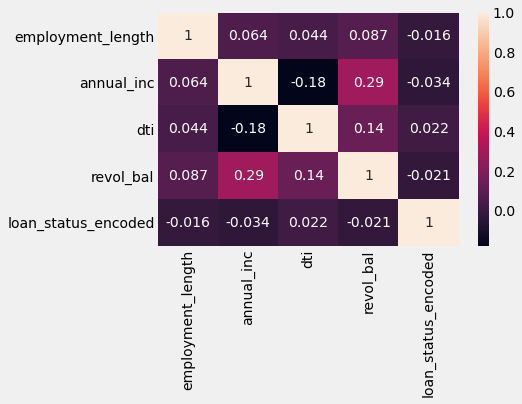

In [62]:
sns.heatmap(df_ability.corr(), annot=True)

It can be seen that the feature most closely related to loan status in the repayment ability category is the annual income (negative correlation, the higher the income, the less likely the loan will be bad). Hence I will use annual income to represent loan repayment ability.

<AxesSubplot:>

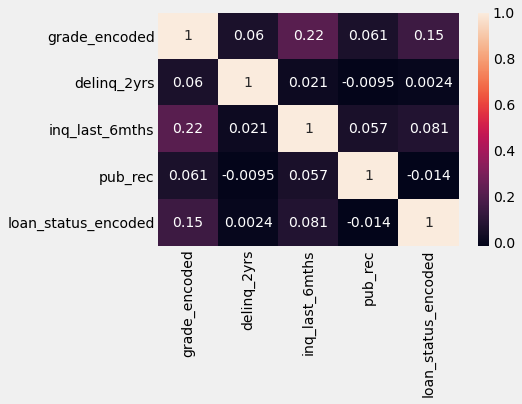

In [63]:
sns.heatmap(df_willingness.corr(), annot=True)

The feature most clostly related to loan status in the repayment willingness category is the credit grade (positive correlation, the higher the grade, the more likely the loan will be bad). Therefore, I will use grade to represent loan repayment willingness.

In [12]:
#data frame for features to be used for clustering
df_cluster = df_cleaned[['loan_amnt','annual_inc','grade_encoded']]

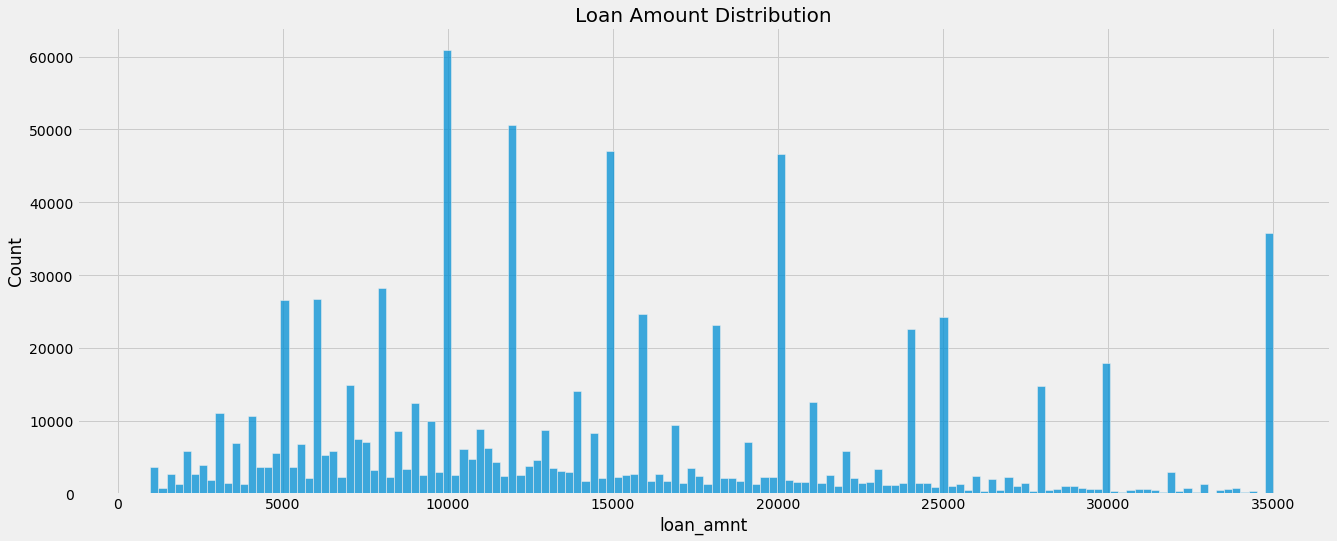

In [103]:
#plot loan_amnt
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['loan_amnt'])
plt.title('Loan Amount Distribution', fontsize = 20)
plt.show()

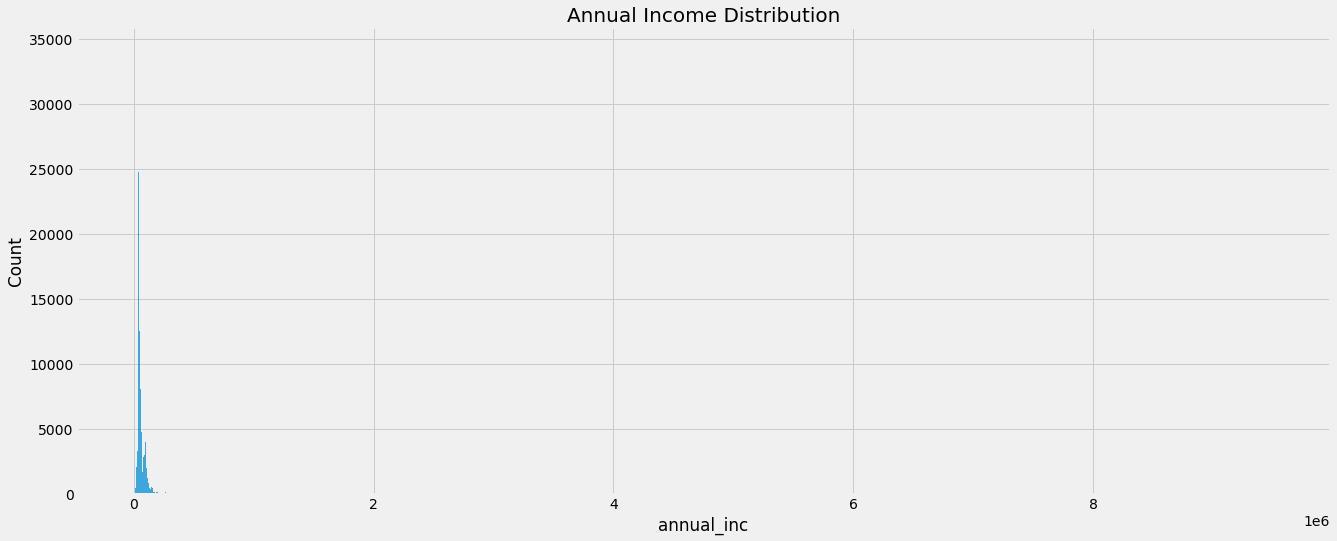

In [100]:
#plot annual income
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['annual_inc'])
plt.title('Annual Income Distribution', fontsize = 20)
plt.show()

It looks like the annual income distribution is heavily skewed, we'll log transform the data here.

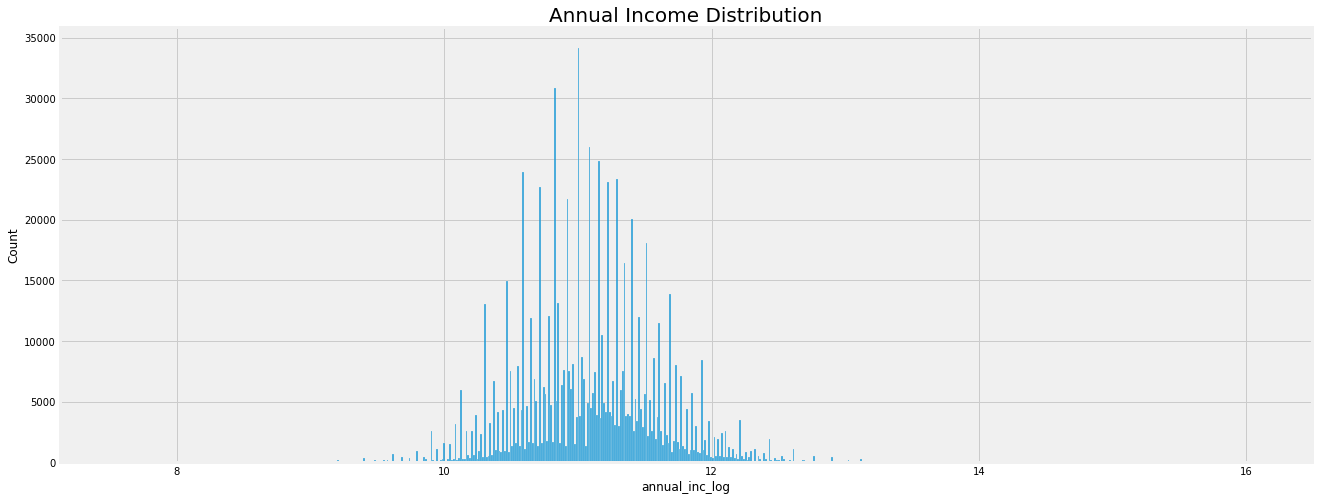

In [13]:
#log transformation of annual income
df_cluster['annual_inc_log'] = np.log1p(df_cluster['annual_inc'])
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['annual_inc_log'])
plt.title('Annual Income Distribution', fontsize = 20)
plt.show()

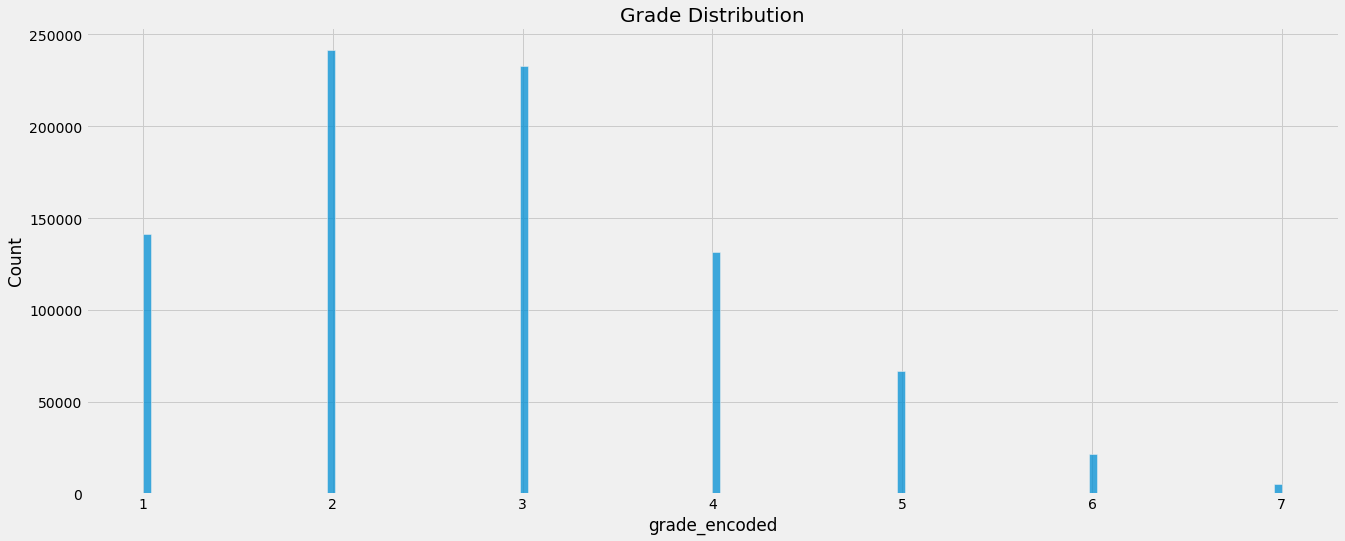

In [104]:
#plot grade
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['grade_encoded'])
plt.title('Grade Distribution', fontsize = 20)
plt.show()

In [116]:
df_cluster.head()

,loan_amnt,annual_inc,grade_encoded,annual_inc_log
0,5000,24000,2,10.085851
1,2500,30000,3,10.308986
2,2400,12252,3,9.413526
3,10000,49200,3,10.803669
4,3000,80000,2,11.289794


To prepare the data for the distance-based algorithm K means, we also need to standardize the data.

In [14]:
# #convert features to integers
# df_cluster['loan_amnt_int'] = df_cluster['loan_amnt'].astype(int)
# df_cluster['annual_inc_int'] = df_cluster['annual_inc'].astype(int)
#standardize the data 
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

In [118]:
pd.DataFrame(df_cluster_scaled).describe()

,0,1,2,3
count,8.420670e+05,8.420670e+05,8.420670e+05,8.420670e+05
mean,2.733937e-17,-1.424348e-17,-1.203945e-16,1.041819e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.706127e+00,-1.134342e+00,-1.367264e+00,-6.867332e+00
25%,-7.800084e-01,-4.471151e-01,-6.063243e-01,-6.560832e-01
50%,-2.030335e-01,-1.728581e-01,1.546158e-01,-2.868062e-02
75%,6.017724e-01,2.080543e-01,9.155559e-01,6.010137e-01
max,2.377080e+00,1.435835e+02,3.198376e+00,9.616764e+00


In [31]:
pd.DataFrame(df_cluster_scaled).head()

,0,1,2,3
0,-1.173535,-0.797555,-0.606324,-1.956567
1,-1.469419,-0.706136,0.154616,-1.524793
2,-1.481255,-0.976553,0.154616,-3.257537
3,-0.581766,-0.413595,0.154616,-0.567565
4,-1.410242,0.055689,-0.606324,0.373102


### Loan repayment ability x willingness
We will cluster borrowers based on their annual income (repayment ability) and grade (repayment willingness) first.

In [119]:
data1 = df_cluster_scaled[:,[3,2]]

In [120]:
data1

array([[-1.95656646, -0.60632434],
       [-1.52479276,  0.15461579],
       [-3.25753599,  0.15461579],
       ...,
       [-1.22651554,  0.91555592],
       [-0.04662512,  1.67649605],
       [ 0.80488752, -0.60632434]])

In order to find the optimal number of clusters (k), we will calculate the winthin-cluster-sum-of-squares (wcss) and choose the number k using the elbow point graph.


In [122]:
#calculate wcss for each number of k
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(data1)
    wcss.append(km.inertia_)

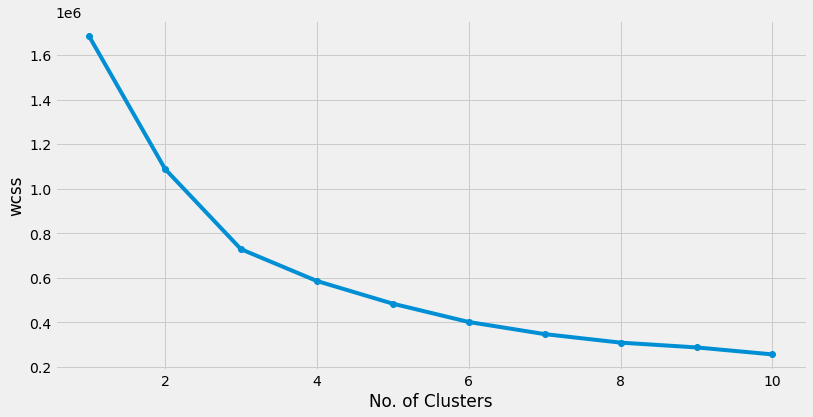

In [123]:
#The elbow point graph
plt.figure(figsize=(12,6))
plt.plot(range(1, 11), wcss, marker = 'o')
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

It seems that the optimal number of clusters is 4 (which is close to the 'elbow' point). 
Next, we will visualize the clusters.

In [131]:
#k = 4
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(data1)

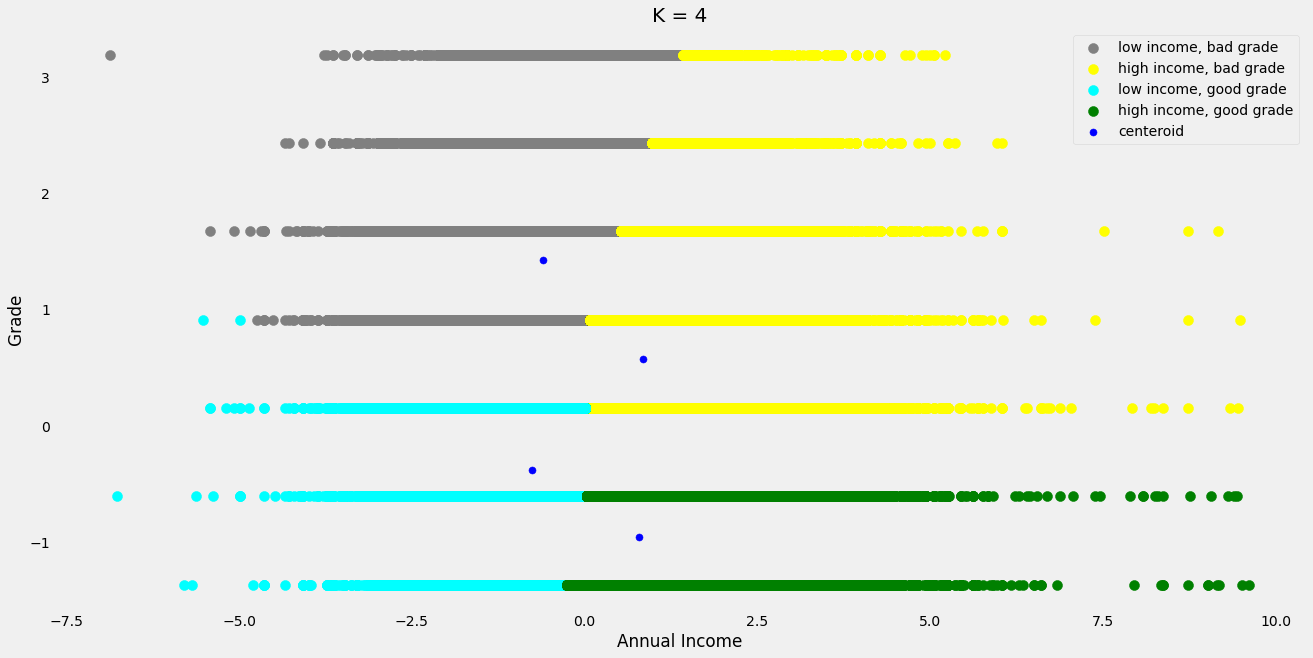

In [134]:
plt.figure(figsize=(20,10))
plt.scatter(data1[y_means == 0, 0], data1[y_means == 0, 1], s = 100, c = 'grey', label = 'low income, bad grade')
plt.scatter(data1[y_means == 1, 0], data1[y_means == 1, 1], s = 100, c = 'yellow', label = 'high income, bad grade')
plt.scatter(data1[y_means == 2, 0], data1[y_means == 2, 1], s = 100, c = 'cyan', label = 'low income, good grade')
plt.scatter(data1[y_means == 3, 0], data1[y_means == 3, 1], s = 100, c = 'green', label = 'high income, good grade')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('K = 4', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Grade')
plt.legend()
plt.grid()
plt.show()

Although grade is an ordinal variable, which is not optimal for kmeans algorithm, this clustering analysis still shows clear insights that borrowers can be segmented into 4 different types based on their annual income (loan repayment ability) and grade (loan repayment willingness). 
<br><br>
Those with high income and good grade (green) are the ideal borrowers who should be retained by the Lending Club, bonus or vouchers can be given to these clients so that they are more willing to keep using the platform; those with low income and bad grade (grey) are risky borrowers that the platform may want to avoid or at least pay close attention to in order to reduce any potential risk; those with high income and bad grade (yellow) are the borrowers that need to be reminded from time to time to repay their loan, they have the ability to repay the loan but they may forget to do so; while those with low income and good grade (cyan) are borrowers who have good credibility but may not be able to repay their loan on time if the loan amount is way too large, so it may be helpful to set a loan amount limit on these borrowers based on their income. 
<br><br>
These are helpful insights that can help enhance lending club's borrower retention rate while keeping the overall risk low. 

### Loan demand x repayment ability
Next, we will do a clustering analysis based on borrowers demand (loan amount) and repayment ability (annual income).

In [135]:
data2 = df_cluster_scaled[:,[3,0]]

In [142]:
#calculate wcss for each number of k
wcss2 = []
for k in range(1, 11):
    km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
    km.fit(data2)
    wcss2.append(km.inertia_)

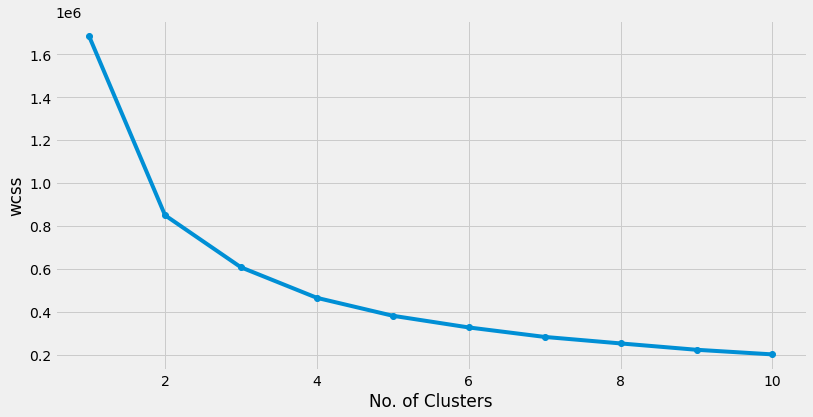

In [143]:
#The elbow point graph
plt.figure(figsize=(12,6))
plt.plot(range(1, 11), wcss2, marker = 'o')
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Again, it looks like 4 is the optimal number of clusters.

In [144]:
#k = 4
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
y_means = km.fit_predict(data2)

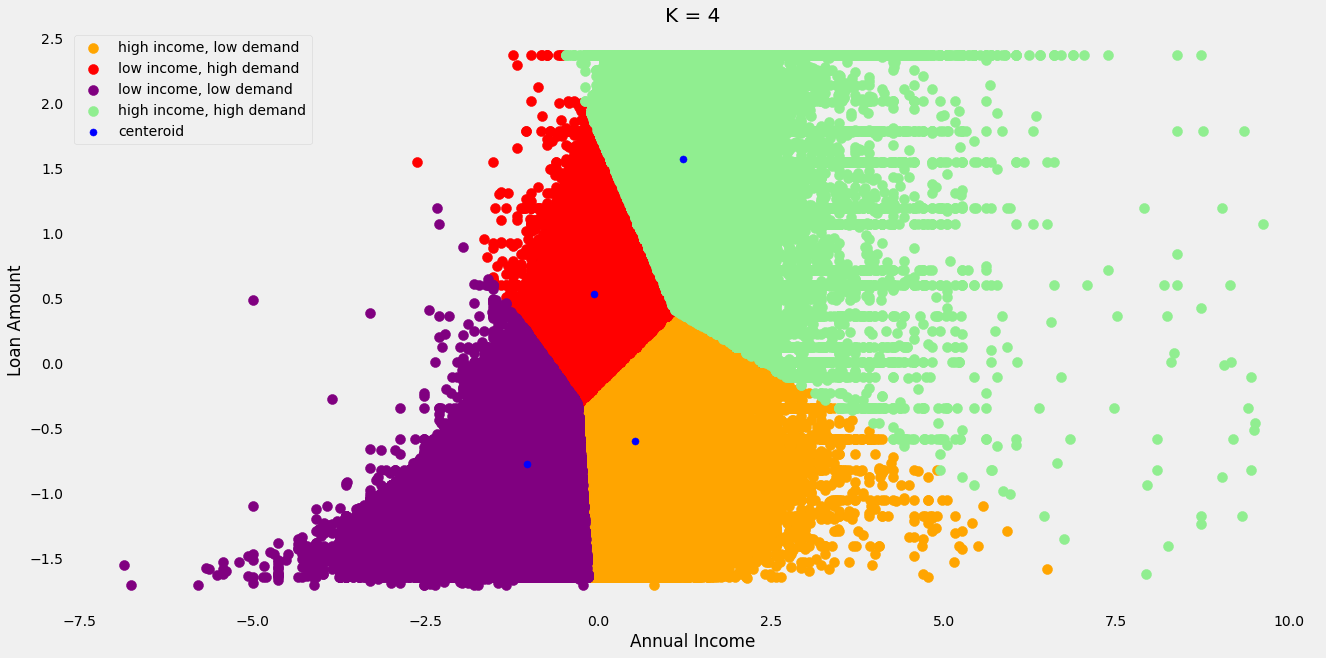

In [147]:
plt.figure(figsize=(20,10))
plt.scatter(data2[y_means == 0, 0], data2[y_means == 0, 1], s = 100, c = 'orange', label = 'high income, low demand')
plt.scatter(data2[y_means == 1, 0], data2[y_means == 1, 1], s = 100, c = 'red', label = 'low income, high demand')
plt.scatter(data2[y_means == 2, 0], data2[y_means == 2, 1], s = 100, c = 'purple', label = 'low income, low demand')
plt.scatter(data2[y_means == 3, 0], data2[y_means == 3, 1], s = 100, c = 'lightgreen', label = 'high income, high demand')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('K = 4', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.legend()
plt.grid()
plt.show()

We can learn from this analysis that borrowers with high income and high demand (light green) are priority clients that contribute the most to Lending Club. Borrowers with high income and low demand (orange) are targeted clients, the platform can use measures such as bonus to stimulate them more. Borrowers with low income and high demand (red) are risky clients whom should be kept an eye on, the platform can probably set a loan amount limit on these clients. Borrowers with low income and low demand (purple) are relatively less important to the platform.

### Loan demand x repayment willingness 
Segmentation and clustering based on borrowers' demand (loan amount) and repayment willingness (grade).

In [19]:
data3 = df_cluster_scaled[:,[0,2]]

In [20]:
#k = 4
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
y_means = km.fit_predict(data3)

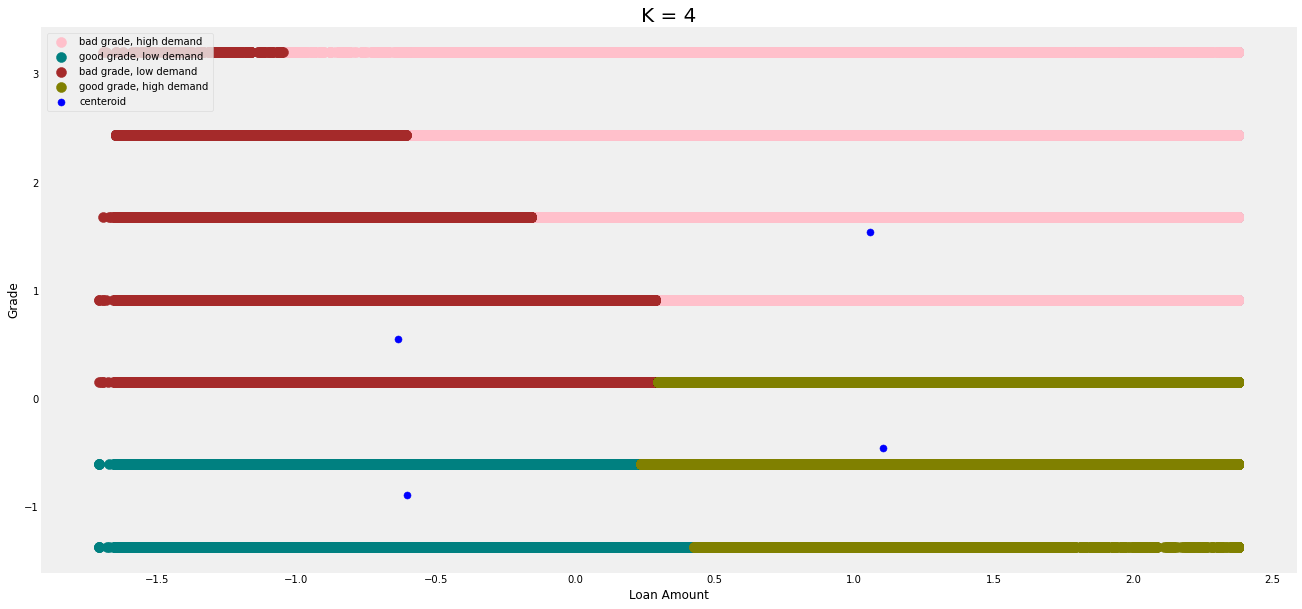

In [22]:
plt.figure(figsize=(20,10))
plt.scatter(data3[y_means == 0, 0], data3[y_means == 0, 1], s = 100, c = 'pink', label = 'bad grade, high demand')
plt.scatter(data3[y_means == 1, 0], data3[y_means == 1, 1], s = 100, c = 'teal', label = 'good grade, low demand')
plt.scatter(data3[y_means == 2, 0], data3[y_means == 2, 1], s = 100, c = 'brown', label = 'bad grade, low demand')
plt.scatter(data3[y_means == 3, 0], data3[y_means == 3, 1], s = 100, c = 'olive', label = 'good grade, high demand')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('K = 4', fontsize = 20)
plt.xlabel('Loan Amount')
plt.ylabel('Grade')
plt.legend()
plt.grid()
plt.show()

Here, we segmented borrowers based on their demand and credibility. The ones with high demand but bad grade (pink) are the most risky group of borrowers that the platform need to pay attention to, while borrowers with high demand and good grade (olive) should be encouraged to use the service more often. Borrowers with good grade but low demand (teal) are potential targets, their repayment ability (annual income) should also be checked in order to take further measures on marketing. Clients with bad grade and low demand (brown) are also risky, but may not cause as much damage as the pink group.
<br><br>
Overall, these clustering analyses provide us with lots of insights on targeted marketing and risk management.

## Loan Demand Time Series Analysis

In [11]:
df_cleaned.head(3)

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util,employment_length,issue_date,loan_status_combined,loan_status_encoded,grade_encoded
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0,1,9,0.0,0,13648.0,83.7,10,2011-12-01,good_loan,0,2
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0,5,4,0.0,0,1687.0,9.4,0,2011-12-01,bad_loan,1,3
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0,2,10,0.0,0,2956.0,98.5,10,2011-12-01,good_loan,0,3


In [11]:
#subset data 
df_time = df_cleaned[['loan_amnt','issue_date']]
df_time = df_time.set_index('issue_date')

In [12]:
#combine loan amount within each month and resample by month
df_time = df_time.groupby('issue_date').sum()
df_time = pd.DataFrame(df_time.resample('M').first())
df_time.head()

,loan_amnt
issue_date,
2007-06-30,17900.0
2007-07-31,323975.0
2007-08-31,485300.0
2007-09-30,372950.0
2007-10-31,753225.0


### Check and transform the data

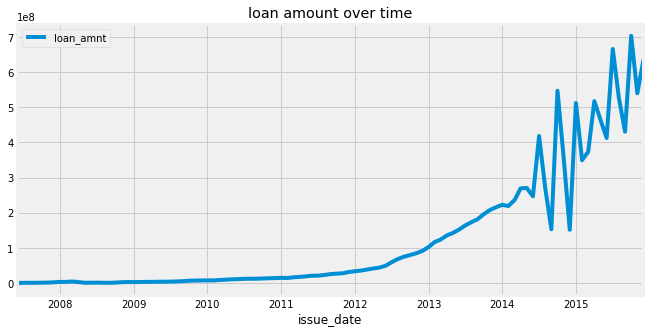

In [14]:
df_time.plot(figsize=(10,5))
plt.title('loan amount over time')
plt.show()

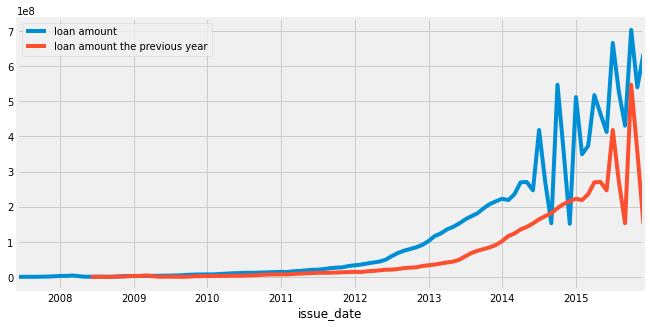

In [64]:
ax = df_time.asfreq('M').plot(figsize=(10,5))
df_time.asfreq('M').shift(12).plot(figsize=(10,5), ax=ax)
plt.legend(['loan amount','loan amount the previous year'])
plt.show()

The comparison between loan amount last year and this year shows that the difference only start to surge after the year 2012. The following charts show a decomposition of the time seriess by trend, seasonality and residual. It is quite obvious that the overal trend is going upward, which means this time series is not stationary.

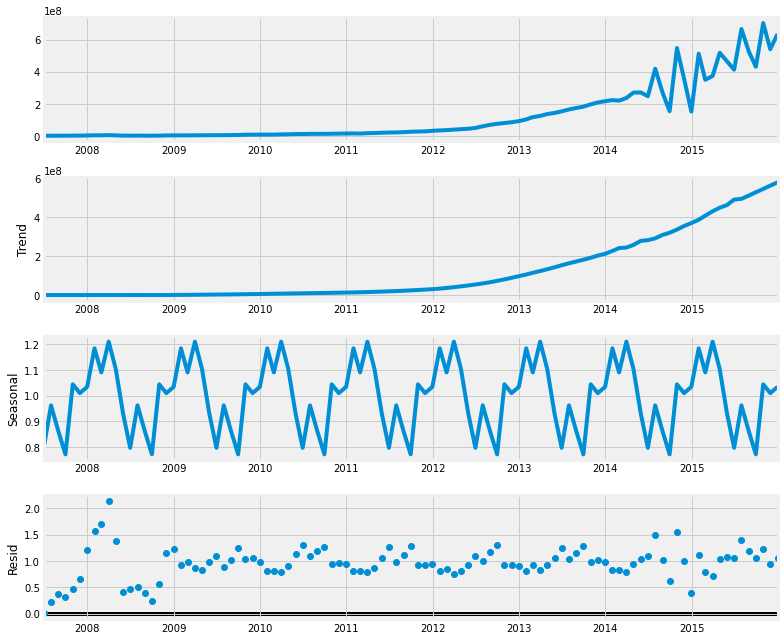

In [21]:
rcParams['figure.figsize'] = 11, 9
decomposed_df_time = sm.tsa.seasonal_decompose(df_time, model='multiplicative', extrapolate_trend='freq') 
figure = decomposed_df_time.plot()
plt.show()

In [13]:
#ADF (Augmented Dickey Fuller) Test
adf=adfuller(df_time)
adf[1]

0.9989726492891332

Indeed the Dickey Fuller test did not show a significant effect, meaning that unit root is present in the time series and that the time series is not stationary. Therefore, in order to perform forcasting models, we need to transform the time series into a stationary one first.

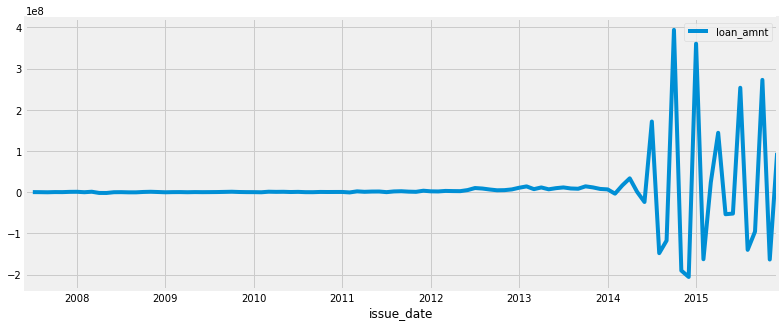

In [13]:
#transform using differencing
rcParams['figure.figsize'] = 12, 5
diff_df_time = df_time.diff()
figure = diff_df_time.plot()
plt.show()

In [16]:
#ADF (Augmented Dickey Fuller) Test
adf=adfuller(diff_df_time.dropna())
adf[1]

1.0

It seems that differencing is not the most suitable way to make the time series stationary. We will try taking the log of the series this time.

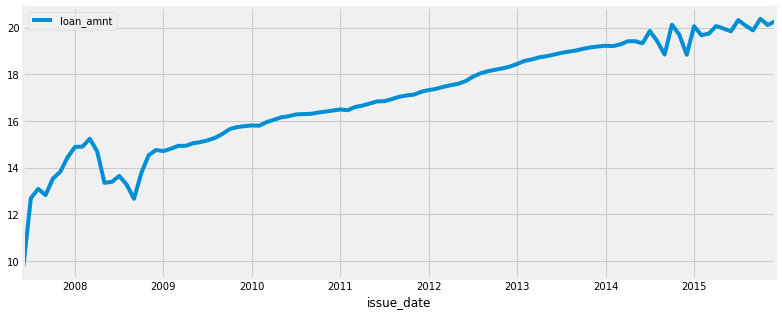

In [24]:
#log transformation
rcParams['figure.figsize'] = 12, 5
log_df_time = np.log(df_time)
figure = log_df_time.plot()
plt.show()

In [26]:
adf=adfuller(log_df_time.dropna())
adf[1]

0.9347907144162075

Ok, still not good enough. In this case, I'll combine log transformation with differencing.

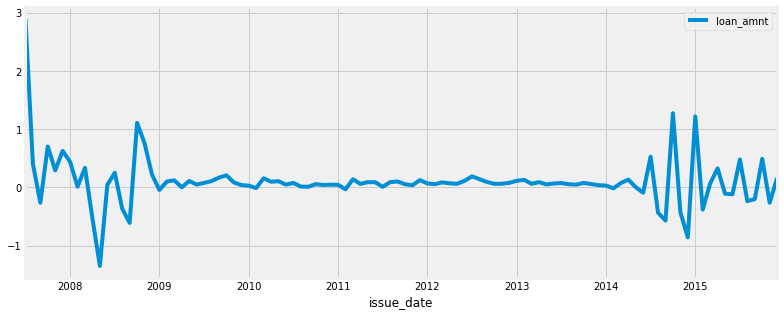

In [45]:
rcParams['figure.figsize'] = 12, 5
logdiff_df_time = np.log(df_time).diff().dropna()
figure = logdiff_df_time.plot()
plt.show()

In [46]:
adf=adfuller(logdiff_df_time)
adf[1]

3.963059002563246e-05

Although the Dickey fuller test indicated a significance (indicated stationarity and constant mean), the transformed series seems to have non-constant variance. This means that ARIMA model might not be the most suitable model, but due to time constraint, I'll leave the task of fitting the variance at another time. <br>

Next, let's check this time series with autocorrelation and partial autocorrelation plot. 

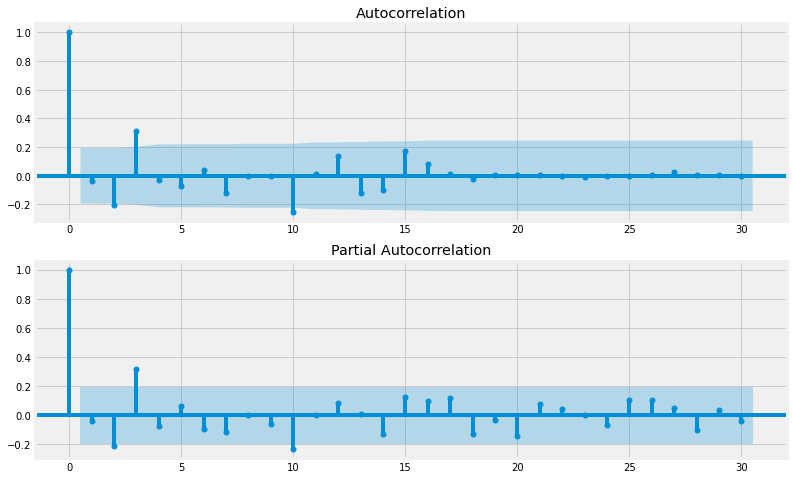

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plot_acf(logdiff_df_time.dropna(), lags=30, ax=ax1);
ax2 = fig.add_subplot(212)
plot_pacf(logdiff_df_time.dropna(), lags=30, ax=ax2);

It seems that the correlations for most lags are below the significance limit in both plots. Since we are going to build an ARIMA model first, the fact that we need to take the difference of the original time series once determines that the difference term d in the model should be 1. And since the first lags of the PACF (partial autocorrelation) plot and the ACF (autocorrelation) plot are already non-significant, the AR (p) and MA (q) term of the model should be 0 or 1. Although we can manually fit an ARIMA model, it's more efficient to use the auto_arima() function provided by pmdarima package for parameter tuning.

### ARIMA model

In [32]:
log_df_time.shape

(103, 1)

In [39]:
#split train and test dataset at a 4:1 ratio
train = log_df_time[:82]
test = log_df_time[82:]

In [49]:
#fit ARIMA model with auto_arima()
model = pm.auto_arima(train, start_p=0, start_q=0, 
                      d = 1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.446, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.213, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=77.429, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.721, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=78.887, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=78.479, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=80.402, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=79.126, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.291 seconds


In [50]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -35.714
Date:                Fri, 12 Feb 2021   AIC                             77.429
Time:                        23:38:43   BIC                             84.612
Sample:                             0   HQIC                            80.311
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1358      0.092      1.482      0.138      -0.044       0.315
ma.L1          0.6812      0.068      9.992      0.000       0.548       0.815
sigma2         0.1403      0.013     11.009      0.0

In [133]:
#fit and forcast the model
model = ARIMA(train, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(21, alpha=0.05) #number of test data

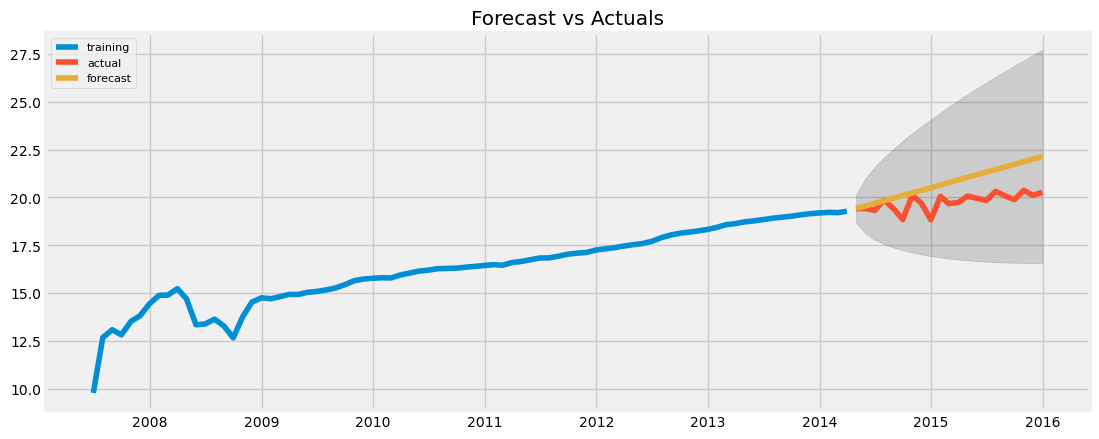

In [134]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Looks like the predicted trend of the loan amount is in the right direction and the 95% confidence interval of the prediction has included the actual loan amount. 

In [138]:
# Accuracy metric using mean absolute percentage error (MAPE)
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return({'mape':mape})

forecast_accuracy(fc, test.values)

{'mape': 0.05705321630596276}

5.7% MAPE indicates that the model is ~94.3% accurate in predicting the next 21 observations. This prediction should help the platform to better allocate resources for loan lending and make suitable arrangement to attract the right amount of investment at the right time.

## Loan Default Prediction
### Data Cleaning

In [139]:
df_cleaned.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util,employment_length,issue_date,loan_status_combined,loan_status_encoded,grade_encoded
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0,1,9,0.0,0,13648.0,83.7,10,2011-12-01,good_loan,0,2
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0,5,4,0.0,0,1687.0,9.4,0,2011-12-01,bad_loan,1,3
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0,2,10,0.0,0,2956.0,98.5,10,2011-12-01,good_loan,0,3
3,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,other,CA,20.00,0,1,37,0.0,0,5598.0,21.0,10,2011-12-01,good_loan,0,3
4,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,other,OR,17.94,0,0,38,766.9,0,27783.0,53.9,1,2011-12-01,good_loan,0,2


In [142]:
df_cleaned['loan_status'].value_counts()

Current                                                568447
Fully Paid                                             200203
Charged Off                                             42680
Late (31-120 days)                                      10863
Issued                                                   7826
In Grace Period                                          6013
Late (16-30 days)                                        2213
Does not meet the credit policy. Status:Fully Paid       1935
Default                                                  1147
Does not meet the credit policy. Status:Charged Off       740
Name: loan_status, dtype: int64

In [322]:
#remove ongoing loan (loan status is 'current' and 'issued')
df_loan = df_cleaned[(df_cleaned['loan_status'] != 'Current') & (df_cleaned['loan_status'] != 'Issued')] 

In [148]:
df_loan['loan_status'].value_counts()

Fully Paid                                             200203
Charged Off                                             42680
Late (31-120 days)                                      10863
In Grace Period                                          6013
Late (16-30 days)                                        2213
Does not meet the credit policy. Status:Fully Paid       1935
Default                                                  1147
Does not meet the credit policy. Status:Charged Off       740
Name: loan_status, dtype: int64

In [149]:
# The classes are skewed, we need to keep the proportion of the good/bad loan when spliting the data to train and test sets.
print('good loan', round(df_loan['loan_status_combined'].value_counts()[0]/len(df_loan) * 100,2), '% of the dataset')
print('bad loan', round(df_loan['loan_status_combined'].value_counts()[1]/len(df_loan) * 100,2), '% of the dataset')

good loan 76.05 % of the dataset
bad loan 23.95 % of the dataset


In [323]:
#drop redundant/irrelevant columns 
df = df_loan.drop(['funded_amnt_inv','grade','emp_length','issue_d','loan_status',
                    'addr_state','issue_date','loan_status_combined'], axis=1)

In [165]:
df.head(3)

,loan_amnt,term,int_rate,installment,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util,employment_length,loan_status_encoded,grade_encoded
0,5000.0,36 months,10.65,162.87,RENT,24000.0,Verified,credit_card,27.65,0,1,9,0.0,0,13648.0,83.7,10,0,2
1,2500.0,60 months,15.27,59.83,RENT,30000.0,Source Verified,car,1.00,0,5,4,0.0,0,1687.0,9.4,0,1,3
2,2400.0,36 months,15.96,84.33,RENT,12252.0,Not Verified,small_business,8.72,0,2,10,0.0,0,2956.0,98.5,10,0,3


In [173]:
df['purpose'].value_counts()

debt_consolidation    157140
credit_card            51834
home_improvement       15543
other                  14938
major_purchase          6481
small_business          5106
car                     3682
medical                 2931
moving                  2116
wedding                 1994
house                   1745
vacation                1603
educational              410
renewable_energy         271
Name: purpose, dtype: int64

In [325]:
#combine 'other','none','any' in 'home_ownership'
df['home_ownership_combined'] = df['home_ownership'].replace(['OTHER','NONE','ANY'],'MISC')

In [326]:
#recomebine values in 'purpose'
df['purpose_combined'] = df['purpose'].replace(['home_improvement','car','major_purchase',
                                                'moving','house'],'property')
df['purpose_combined'] = df['purpose_combined'].replace(['wedding','vacation'],'recreation')
df['purpose_combined'] = df['purpose_combined'].replace(['renewable_energy'],'other')

In [178]:
df['purpose_combined'].value_counts()

debt_consolidation    157140
credit_card            51834
property               29567
other                  15209
small_business          5106
recreation              3597
medical                 2931
educational              410
Name: purpose_combined, dtype: int64

In [327]:
df= df.drop(['home_ownership','purpose'],axis=1)

<AxesSubplot:>

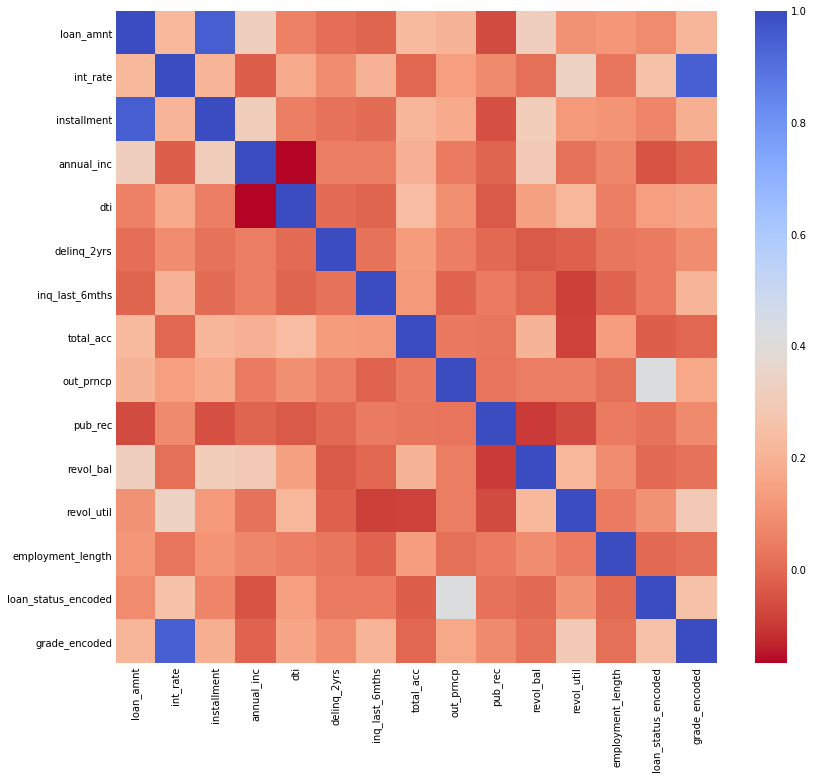

In [258]:
#plot heatmap to check correlations
plt.subplots(figsize=(12,12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

It seems that a few pairs of predictors are highly correlated, including loan_amnt and installment, grade_encoded and int_rate. I will remove installment and int_rate from the dataframe.

In [328]:
df = df.drop(['int_rate','installment'], axis=1)

<AxesSubplot:>

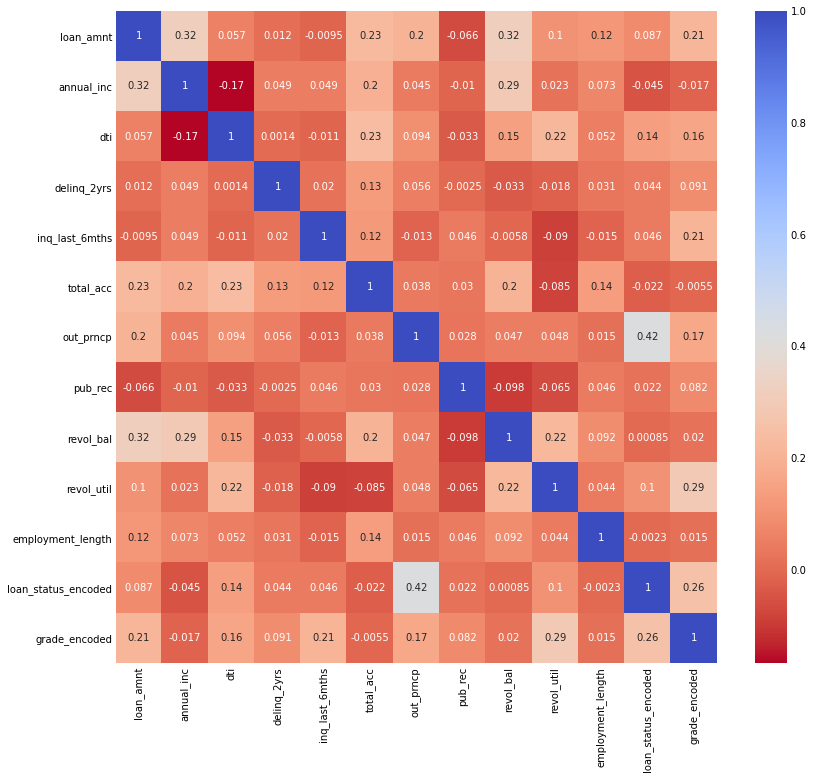

In [435]:
plt.subplots(figsize=(12,12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True)

The heatmap shows that the factors that are most correlated with loan status includes out_prncp (remaining outstanding principal for total amount funded), grade (credit score) and dti (debt-income ratio).  

In [330]:
columns_for_scale = df.columns.drop(['loan_status_encoded','term',
                                             'verification_status','home_ownership_combined',
                                             'purpose_combined'])

In [331]:
columns_for_scale

Index(['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'total_acc', 'out_prncp', 'pub_rec', 'revol_bal', 'revol_util',
       'employment_length', 'grade_encoded'],
      dtype='object')

In [332]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[columns_for_scale])

In [333]:
df_scaled = pd.DataFrame(scaled_data, columns=columns_for_scale)

In [337]:
df_scaled.sample(3)

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util,employment_length,grade_encoded
187773,0.145778,-0.382622,0.117694,-0.343526,0.966675,0.077768,-0.236652,-0.324877,-0.228209,-0.677274,0.326505,-0.637295
55361,0.755797,1.612358,-0.858777,3.551168,1.833483,-0.176513,-0.236652,1.930997,-0.716198,-2.026460,0.050884,2.304053
206616,-0.586244,-0.382622,1.291497,-0.343526,0.099868,-0.515553,-0.236652,-0.324877,-0.246574,0.534571,-0.775978,-1.372633


In [381]:
df1=df.copy()
# .values is crucial here to avoid implicitly joining by the hidden unique id
df1[columns_for_scale] = df_scaled[columns_for_scale].values

In [389]:
#one-hot encoding categorical variables
df_encoded = pd.get_dummies(df1, columns=['term','verification_status',
                                            'home_ownership_combined','purpose_combined'])

### Classification

In [390]:
#define predictors X and dependent variable y
X = df_encoded.drop('loan_status_encoded', axis=1)
y = df_encoded['loan_status_encoded']
#split train and test data based on dependent variable proportion
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.76050622 0.23949378]
[0.76050641 0.23949359]


In [391]:
#keep spliting the train dataset into train and validation sets
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    Xtrain, Xval = X.iloc[train_index], X.iloc[test_index]
    ytrain, yval = y.iloc[train_index], y.iloc[test_index]
    
# Turn into an array
Xtrain = Xtrain.values
Xval = Xval.values
ytrain = ytrain.values
yval = yval.values

Next, we'll fit two classifiers the logistic regression and random forest classifier. Since the task is default prediction, it is important that our prediction results can cover as many positive cases as possible, since one default can potentially lead to very high cost. Therefore, 'recall' (the percentage of true positive out of all actual positive cases) is more crucial than precision (the percantage of true positive out of all predicted positive cases) when evaluating our results. Both ROC and f1 score will be good summarising score for this purpose.

#### Logistic Regression

In [495]:
## Logistic Regression 
log_reg_params = {"penalty": ['l2'], 
                  'C': [800, 1000, 1200],
                 "class_weight":['balanced']}
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid=log_reg_params, cv=5, scoring='f1')
grid_log_reg.fit(Xtrain, ytrain)
#get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [496]:
grid_log_reg.best_params_

{'C': 800, 'class_weight': 'balanced', 'penalty': 'l2'}

In [497]:
#check scores
log_reg_pred = cross_val_predict(log_reg, Xtrain, ytrain, cv=5, method="predict")

In [498]:
print('Logistic Regression roc: ', roc_auc_score(ytrain, log_reg_pred))

Logistic Regression roc:  0.6748975823525702


In [499]:
print(classification_report(ytrain, log_reg_pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.80    129369
           1       0.43      0.59      0.50     40740

    accuracy                           0.72    170109
   macro avg       0.64      0.67      0.65    170109
weighted avg       0.75      0.72      0.73    170109



In [500]:
#check validation scores
print('Logistic Regression roc: ', roc_auc_score(yval, log_reg.predict(Xval)))

Logistic Regression roc:  0.7059956433780086


In [501]:
print(classification_report(yval, log_reg.predict(Xval)))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     36118
           1       0.28      0.76      0.41      6409

    accuracy                           0.67     42527
   macro avg       0.61      0.71      0.59     42527
weighted avg       0.84      0.67      0.71     42527



#### Random Forest

In [469]:
## random forest classifier
rf_params = {
    'n_jobs': [-1],
    'n_estimators': [200,300],
    'max_depth': [5,6],
    'min_samples_leaf': [1],
     'class_weight': ['balanced', 'balanced_subsample']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=5, scoring='f1')
grid_rf.fit(Xtrain, ytrain)
rf_clf = grid_rf.best_estimator_

In [470]:
grid_rf.best_params_

{'class_weight': 'balanced',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'n_estimators': 200,
 'n_jobs': -1}

In [472]:
#check other scores
rf_pred = cross_val_predict(rf_clf, Xtrain, ytrain, cv=5, method="predict")

In [490]:
print('Random Forest Classifier roc: ', roc_auc_score(ytrain, rf_pred))

Random Forest Classifier roc:  0.66998454267958


In [489]:
print(classification_report(ytrain, rf_pred))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80    129369
           1       0.42      0.59      0.49     40740

    accuracy                           0.71    170109
   macro avg       0.64      0.67      0.65    170109
weighted avg       0.75      0.71      0.72    170109



In [488]:
#check validation score
print('Random Forest Classifier roc: ', roc_auc_score(yval, rf_clf.predict(Xval)))

Random Forest Classifier roc:  0.6997567464305013


In [487]:
print(classification_report(yval, rf_clf.predict(Xval)))

              precision    recall  f1-score   support

           0       0.94      0.63      0.75     36118
           1       0.27      0.77      0.40      6409

    accuracy                           0.65     42527
   macro avg       0.60      0.70      0.58     42527
weighted avg       0.84      0.65      0.70     42527



Looks like logistic regression has an overall better performance, so I will use logistic regression for the final prediction of the test set.
#### Prediction Results

In [502]:
##final prediction using logistic regression with the best parameters and all training data
log_reg_final = LogisticRegression(penalty= 'l2', C=800, class_weight='balanced').fit(original_Xtrain, original_ytrain)
predictions = log_reg_final.predict(original_Xtest)

In [503]:
##score with test set
print('logistic regression roc: ', roc_auc_score(original_ytest, predictions))

logistic regression roc:  0.7911066265347366


In [504]:
print(classification_report(original_ytest, predictions))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     40427
           1       0.48      0.88      0.62     12731

    accuracy                           0.74     53158
   macro avg       0.72      0.79      0.71     53158
weighted avg       0.84      0.74      0.76     53158



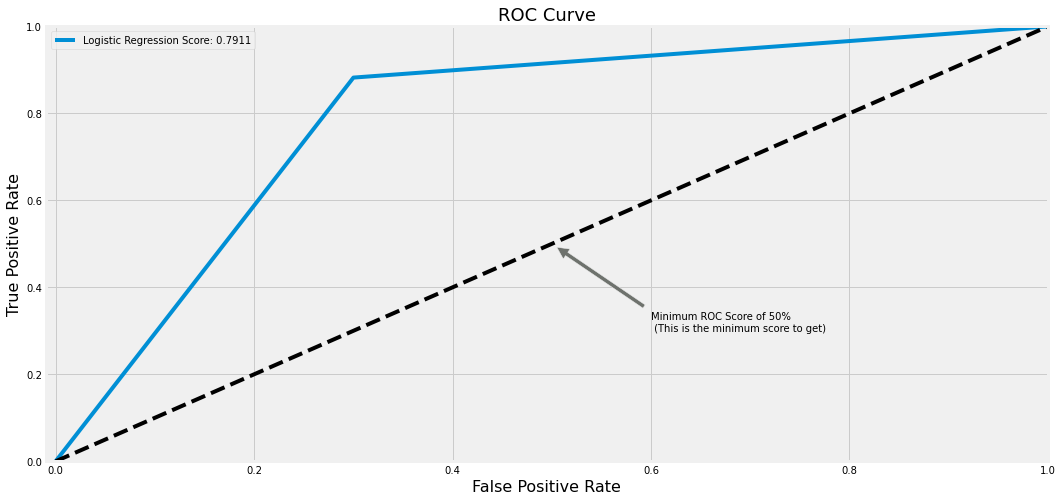

In [506]:
#plot roc curve 
lr_fpr, lr_tpr, lr_thresold = roc_curve(original_ytest, predictions)

def graph_roc_curve(lr_fpr, lr_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve', fontsize=18)
    plt.plot(lr_fpr, lr_tpr, label='Logistic Regression Score: {:.4f}'.format(roc_auc_score(original_ytest, predictions)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve(lr_fpr, lr_tpr)
plt.show()

Overall, logistic regrssion with balanced weights leads to a relatively good prediction results with high sensitivity (true positive rate) and a moderately low false alarm rate (false positive rate). This should help the platform predict most of the default cases with a relatively low cost. If time allows, over sampling method (SMOTE) is also worth trying to enhance the prediction results. 